In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.nn import functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.models.resnet import resnet50


from PIL import Image

import time
from pylab import *
from IPython.display import *



In [2]:
rcParams['figure.figsize'] = 18,7
rcParams['axes.grid'] = True
rcParams['font.size'] = 15
style.use('dark_background')

In [3]:
device = torch.device('cuda') # using GPU
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.to(device)
model.eval() # puts the resnet model into evaluation mode which is good cause we don't want to change the model as this is an adversarial attack
for param in model.parameters(): #making sure that no gradients are tracked while we use the model
    param.requires_grad = False

Using cache found in C:\Users\Jonat/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Jonat\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Jonat\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:

pimg_size = (224,224) # resnet image size is 224,224 with 3 channels
img_size = (32,32) # size of Cifar 10 images. Also has 3 channels
mask_size = pimg_size #size of masking matrix
num_channels = 3 # num channels for resnet

batch_size = 50

In [5]:
pad = int((pimg_size[0]-img_size[0])/2) # finding what padding I need on each border of the input image


transform = transforms.Compose([
    transforms.Pad(padding = pad),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# adding padding, normalizing the data, and using lambda to up the num of channels

train_dataset = datasets.CIFAR10(root = 'data/', train=True, transform=transform, download=True) # download  dataset

test_dataset = datasets.CIFAR10(root = 'data/', train=False, transform=transform)


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, shuffle=True
)



test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, shuffle=False
)

Files already downloaded and verified


In [6]:
program = torch.rand(num_channels, *pimg_size, device=device, requires_grad = True) #creating our adversarial program starting point by making a random tensor, which we will adjust later


pad = int((mask_size[0]-img_size[0])/2) 

mask = torch.zeros(num_channels, *img_size, device=device) # creating the mask
mask = F.pad(mask, (pad,pad,pad,pad), value=1)

optimizer = torch.optim.Adam([program], lr=0.05) #the optimizer which optimizes our adversarial program
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma =0.96)# to adjust the learning rate as time goes on

loss_criterion = nn.CrossEntropyLoss() # loss criterion


num_classes = 10 

In [7]:
def predict_on_batch(model, batch, program = None):
    if program is not None:
        batch = batch + torch.tanh(program * mask)
    outputs = model(batch)
    pred_labels = torch.argmax(outputs, dim=-1)
    return pred_labels

In [8]:
def getHists(model, loader, model_output_count=1000, data_label_count=10 , program = None):
    """
    Get histrogram of model outputs using dataset for another problem. 
    Example, get histrogram of resnet18 outputs on scaled mnist digits.
    """
    with torch.no_grad():
        hists = torch.zeros(data_label_count,model_output_count)
        d = display(Markdown(''), display_id=f'info{time.time()}')
        i=0
        if program is not None:
            print("program is there")
        for imgs, labels in loader:
            i+=1
            preds = predict_on_batch(model,imgs.to(device),program = program)
            for l,p in zip(labels,preds):
                hists[l][p]+=1
            d.update(Markdown(f"Batch {i} done"))
            
        return hists

In [9]:
hists_cifar_inception_normtanh = getHists(model, train_loader)
h_inception_cif = hists_cifar_inception_normtanh.cpu().numpy()

Batch 1000 done

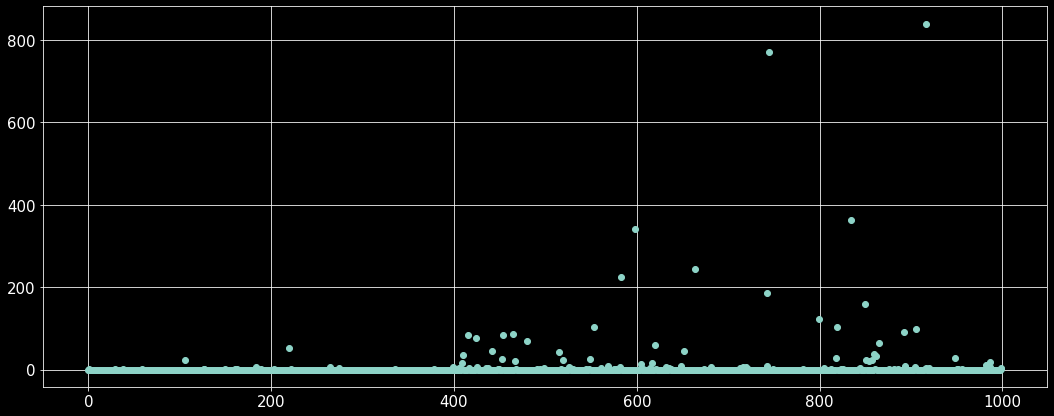

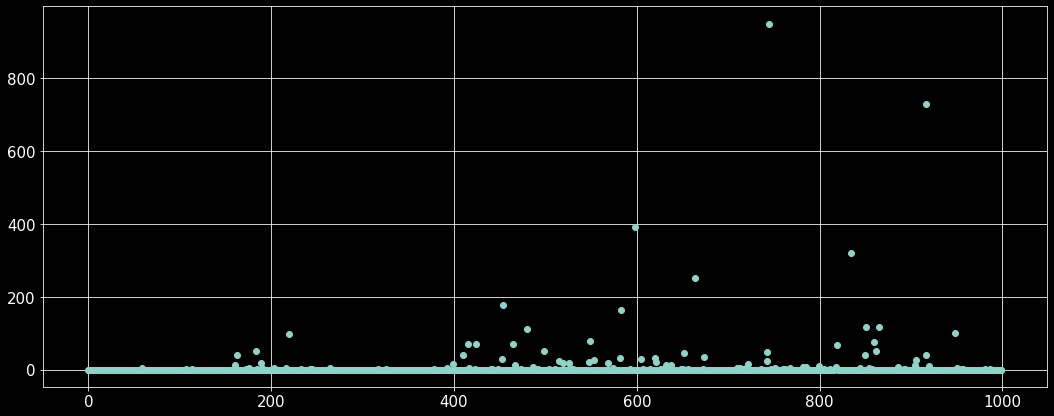

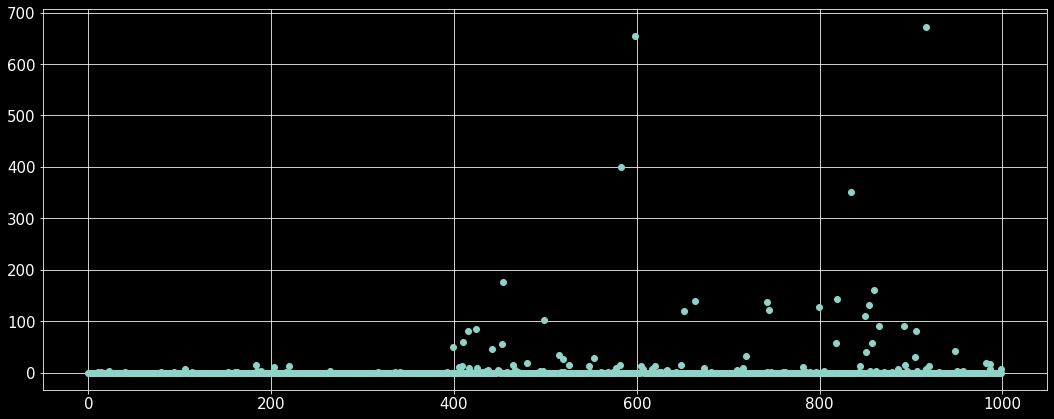

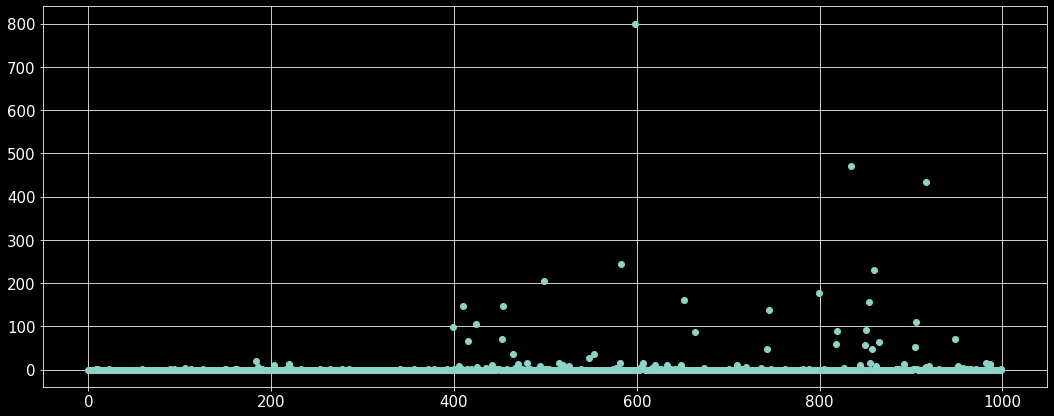

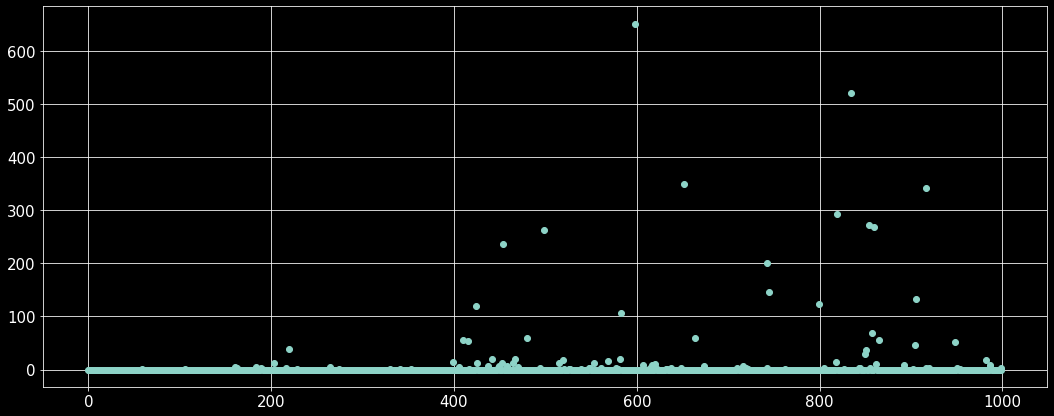

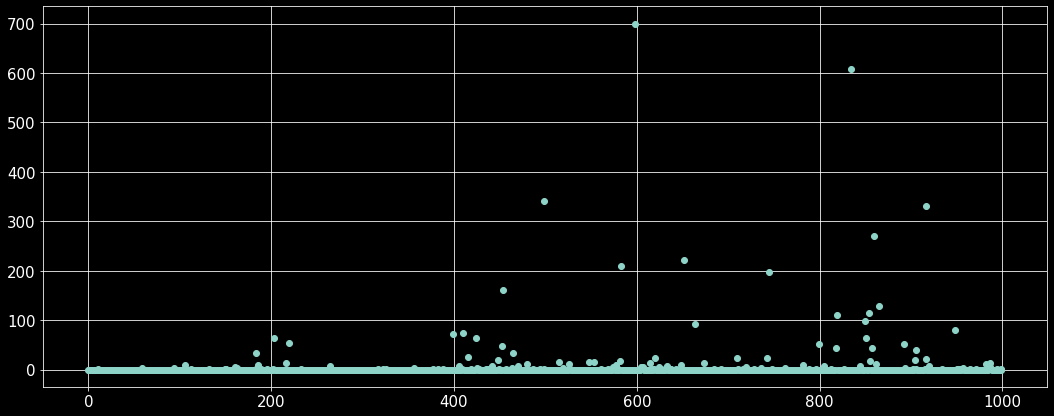

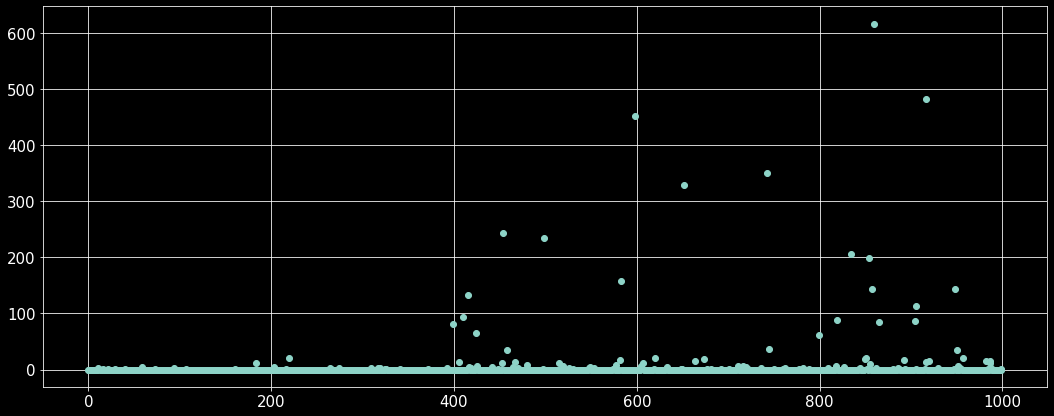

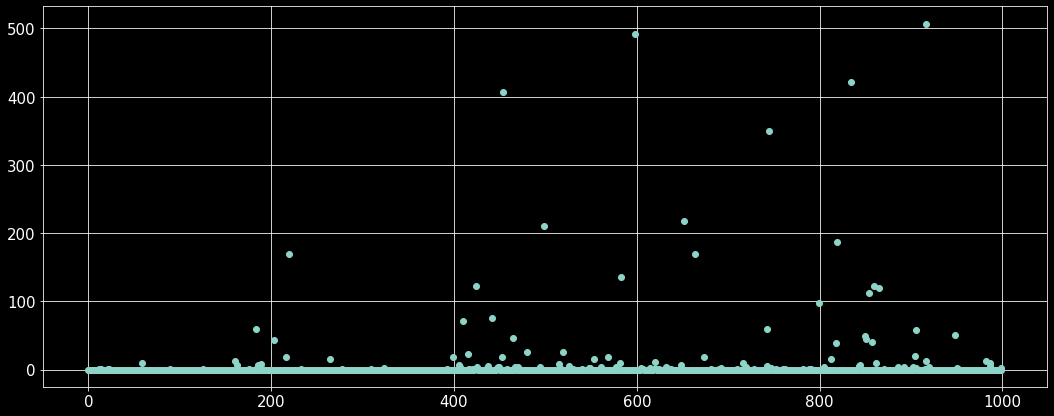

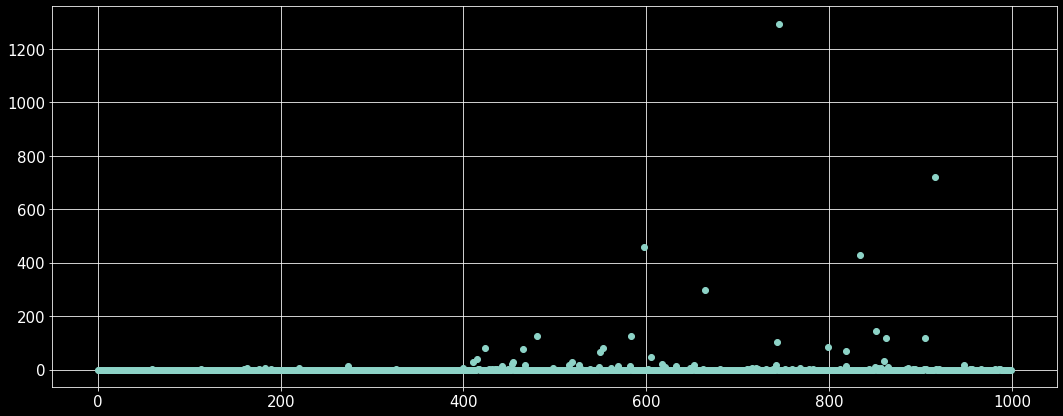

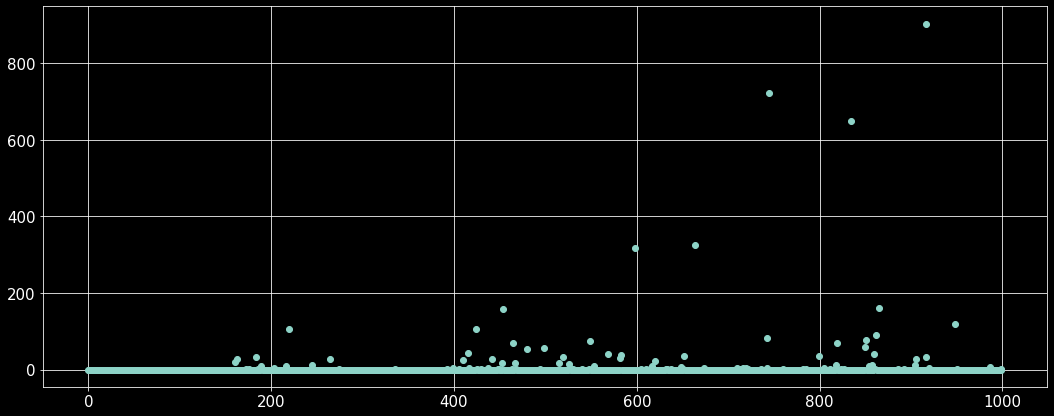

In [10]:
for i in range(10):
    plot(h_inception_cif.T[:,i],'o')
    show()

In [11]:
sorteds = argmax(h_inception_cif.T, axis=0)
argstoreds = argsort(h_inception_cif.T, axis=0)
h_inception_cif = hists_cifar_inception_normtanh.cpu().numpy()
h_inception_cif.shape

(10, 1000)

In [12]:
inception_mapping = argmax(h_inception_cif, axis=0)
print(inception_mapping)

[0 0 0 0 0 0 0 0 3 0 0 6 6 0 2 0 6 0 0 0 0 6 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 6
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 3 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 3 1 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 5 3 0 2 0 0 0 0 0 0 9 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 7 0
 5 5 0 0 1 1 0 0 0 0 0 5 0 0 0 0 0 5 5 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 7 0
 0 3 0 0 0 0 4 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 0 9 0 0 0 0 0 0 0 3 0 0 0 0 0
 0 0 0 0 0 9 0 6 0 0 0 0 0 0 0 8 0 0 7 3 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 6 0 6 0 0 5 0 7 6 8 0 0 0 4 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 4 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 3 0 0 0 0 5 0 0 0 0 5 0 0 0 0 0 5 0 0 0 1 0 0 0 0 0 0 3 3 0 0 0 0 0 6
 2 0 0 3 0 0 0 3 6 2 6 0 6 0 7 0 1 7 4 0 5 8 0 9 2 0 0 0 0 0 4 0 3 1 0 7 0
 0 0 0 3 5 4 0 0 0 3 7 0 0 5 6 0 0 0 0 0 5 0 0 0 1 0 3 0 0 1 3 0 0 0 0 0 8
 0 0 3 0 0 0 1 0 0 0 0 1 

In [13]:
print(h_inception_cif[0])

[  0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  22.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   2.   0.   0.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   7.   0.   0.   2.   0.   0.   2.   0.   0.   0.   0.   0.   0.
   0. 

In [14]:
total_correct = 0
total = 0
for i in range(10):
    correct = h_inception_cif[i,where(inception_mapping==i)].sum()
    total_correct += correct
    total += h_inception_cif[i].sum()
    acc = correct/h_inception_cif[i].sum()
    print(i, acc)

print(total_correct/total)


0 0.1322
1 0.0808
2 0.111
3 0.2974
4 0.215
5 0.1126
6 0.3308
7 0.18
8 0.3586
9 0.4344
0.22528


In [15]:
#Training loop
num_epochs = 20
steps_per_epoch = len(train_loader)

for epoch in range(num_epochs):

    if epoch == 0:
      print('Training has started')

    
    total_loss = 0.0

    for i, data in enumerate(train_loader):
        images = data[0].to(device) #grabbing images from the data
        labels = data[1].to(device) #grabbing labels from the data
        
        images = images + torch.tanh(program * mask) #additive contribution to the image

        outputs = model(images)
        probs_mapped = torch.zeros(images.size()[0], 10).to(device)
        for j in range(10):
            a = outputs[:,where(inception_mapping==j)]
            probs_mapped[:,j] = a.squeeze().sum(dim=1)
        
        loss = loss_criterion(probs_mapped, labels)
        
        
        
        
        
        
        
        #probs_model= model(images.to(device))
        #probs = torch.zeros(images.size()[0], 10).to(device)
        #for j in range(10):
         #   a = probs_model[:,where(inception_mapping==j)]
          #  probs[:,j] = a.squeeze().sum(dim=1)
            
        
    
    
        #loss = loss_criterion(probs,labels.to(device))

        #images = images + torch.tanh(program*mask) #additive contribution to the image

        #outputs = model(images) # see what resnet classifies
        #outputs = outputs[:,:num_classes]
     
        #loss = loss_criterion(outputs, labels) # find loss
        loss.backward() # backwards pass
        optimizer.step() #update weights
        optimizer.zero_grad()
    

        total_loss += loss.item() #calculate total loss
       
        if(i+1)%(int(steps_per_epoch/2)) == 0:
            print(f'Epoch {epoch+1}/{num_epochs},  Step {i+1}/{steps_per_epoch},  Loss:  {loss.item()},  Avg Loss for Epoch:  {total_loss/(i+1)}')
    lr_scheduler.step() # adjusting learning rate

Training has started


C:\Users\Jonat\AppData\Local\Temp\ipykernel_3488\1548152771.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  a = outputs[:,where(inception_mapping==j)]


Epoch 1/20,  Step 500/1000,  Loss:  1.4906681776046753,  Avg Loss for Epoch:  2.1645211143493652
Epoch 1/20,  Step 1000/1000,  Loss:  1.4919697046279907,  Avg Loss for Epoch:  1.913529636979103
Epoch 2/20,  Step 500/1000,  Loss:  1.687218189239502,  Avg Loss for Epoch:  1.5453180053234101
Epoch 2/20,  Step 1000/1000,  Loss:  1.2991985082626343,  Avg Loss for Epoch:  1.5153186540603638
Epoch 3/20,  Step 500/1000,  Loss:  1.3562531471252441,  Avg Loss for Epoch:  1.4156520323753357
Epoch 3/20,  Step 1000/1000,  Loss:  1.2522478103637695,  Avg Loss for Epoch:  1.4064191707968712
Epoch 4/20,  Step 500/1000,  Loss:  1.4508028030395508,  Avg Loss for Epoch:  1.3495338640213013
Epoch 4/20,  Step 1000/1000,  Loss:  1.563419222831726,  Avg Loss for Epoch:  1.3301593449115754
Epoch 5/20,  Step 500/1000,  Loss:  1.0782709121704102,  Avg Loss for Epoch:  1.2930872997045517
Epoch 5/20,  Step 1000/1000,  Loss:  1.450679898262024,  Avg Loss for Epoch:  1.2835197924375534
Epoch 6/20,  Step 500/1000,  

# now time to add the program to the test set, and see how much the remapping helped the original model clasify cifar-10

In [22]:
# testing
with torch.no_grad(): 

    total_loss = 0.0
    total_steps = len(test_loader)
    total = 0
    total_correct = 0


    for data in test_loader:
        images = data[0].to(device)
        labels = data[1].to(device) 

        images = images + torch.tanh(program*mask)
        outputs = model(images)

        test_probs_mapped = torch.zeros(images.size()[0], 10).to(device)
        for j in range(10):
            a = outputs[:,where(inception_mapping==j)]
            test_probs_mapped[:,j] = a.squeeze().sum(dim=1)

        preds = torch.argmax(test_probs_mapped, dim = 1) #grabs index of highest pred
        #print(preds, labels)




        total_correct += torch.sum(preds==labels).item() 
        total+= labels.shape[0]



In [23]:
acc = (total_correct/total) * 100.0
print(f'Accuracy: {acc:.4f}')

Accuracy: 63.4700


In [18]:
torch.save({'program':program, 'mask':mask}, 'inception_v3_adversarial_CIFAR10_multi_label.pth')

In [19]:
state = torch.load('inception_v3_adversarial_CIFAR10_multi_label.pth')
program = state['program']
mask = state['mask']

In [20]:
transforms.ToPILImage()(program.detach().cpu())
x,y = train_dataset[0]


torch.max(x)

x.shape



def imshow(img):
    return transforms.ToPILImage()(img.detach().cpu())

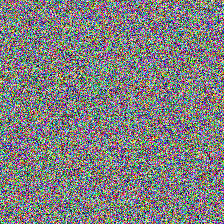

In [21]:
imshow(program)